In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------
# 1. Définir les fonctions de métriques manuelles
# -----------------------------

def confusion_matrix_manual(y_true, y_pred, num_classes):
    """
    Calcule la matrice de confusion manuellement.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true][pred] += 1
    return cm

def precision_recall_f1(cm):
    """
    Calcule la précision, le rappel et le F1-score pour chaque classe à partir de la matrice de confusion.
    """
    precision = {}
    recall = {}
    f1_score = {}
    num_classes = cm.shape[0]

    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp

        precision_cls = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_cls = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_cls = (2 * precision_cls * recall_cls) / (precision_cls + recall_cls) if (precision_cls + recall_cls) > 0 else 0

        precision[cls] = precision_cls
        recall[cls] = recall_cls
        f1_score[cls] = f1_cls

    return precision, recall, f1_score

def accuracy_manual(y_true, y_pred):
    """
    Calcule l'exactitude manuellement.
    """
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

# -----------------------------
# 2. Charger et Prétraiter les Données
# -----------------------------

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/dfplusIQA_NAcomplet.csv'

# Charger les données
df = pd.read_csv(file_path, encoding= "utf-8")


# -----------------------------
# 3. Encodage One-Hot pour 'station' et 'wd'
# -----------------------------

categorical_vars = ['station', 'wd']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
print("\nEncodage One-Hot pour 'station' et 'wd' effectué.")

# -----------------------------
# 4. Convertir les Colonnes Quantitatives en Numériques
# -----------------------------

quantitative_vars = ['TEMP', 'PRES', 'DEWP', 'WSPM', 'RAIN']
for var in quantitative_vars:
    df[var] = pd.to_numeric(df[var], errors='coerce')

print("\nConversion des colonnes quantitatives en numériques effectuée.")

# -----------------------------
# 5. Normalisation des Variables Quantitatives
# -----------------------------

mean = df[quantitative_vars].mean()
std = df[quantitative_vars].std()
df[quantitative_vars] = (df[quantitative_vars] - mean) / std

print("\nNormalisation des variables quantitatives effectuée.")

# -----------------------------
# 6. Encodage des Variables Temporelles en Variables Cycliques
# -----------------------------

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Supprimer les Colonnes Temporelles Originales
df = df.drop(['year', 'month', 'day', 'hour'], axis=1)
print("\nEncodage des variables temporelles en variables cycliques effectué et colonnes originales supprimées.")

# -----------------------------
# 7. Encodage Correct de la Cible avec Ordre Spécifique
# -----------------------------

# Définir l'ordre des catégories souhaitées
desired_order = ['bon', 'modéré', 'non-sain pour sensibles', 'non-sain', 'très non-sain', 'dangereux']

# Convertir 'IQA' en type catégorique avec ordre spécifique
df['IQA'] = pd.Categorical(df['IQA'], categories=desired_order, ordered=True)

# Encodage de la cible
df['IQA_encoded'] = df['IQA'].cat.codes

# Vérifier les types de données après prétraitement
print("\nTypes de données après prétraitement :")
print(df.dtypes)

# Vérifier les valeurs uniques de 'IQA' et gérer les classes non mappées
unique_iqa = df['IQA'].unique()
print("\nValeurs uniques de 'IQA' dans les données:")
print(unique_iqa)

# Identifier les valeurs non mappées
unmapped_iqa = set(unique_iqa) - set(desired_order)
if unmapped_iqa:
    print("\nValeurs de 'IQA' non mappées et seront exclues:")
    print(unmapped_iqa)
    # Exclure ces lignes
    df = df[df['IQA'].isin(desired_order)]
    print(f"Nombre de lignes après exclusion: {len(df)}")
else:
    print("\nToutes les valeurs de 'IQA' sont mappées.")

# Re-encoder 'IQA_encoded' après exclusion
df['IQA_encoded'] = df['IQA'].cat.codes

# Vérifier s'il y a des valeurs manquantes après le mapping
missing_encoded = df['IQA_encoded'].isnull().sum()
if missing_encoded > 0:
    print(f"\nIl y a {missing_encoded} lignes avec 'IQA_encoded' manquant. Elles seront exclues.")
    df = df.dropna(subset=['IQA_encoded'])
    df['IQA_encoded'] = df['IQA_encoded'].astype(int)
else:
    print("\nToutes les lignes ont été correctement encodées.")

# Vérifier le mapping
print("\nMapping des labels :")
for code, category in enumerate(desired_order):
    print(f"Code {code}: {category}")

# -----------------------------
# 8. Préparer les Séquences
# -----------------------------

sequence_length = 24
features = df.drop(['IQA', 'IQA_encoded'], axis=1).values
target = df['IQA_encoded'].values

def create_sequences(features, target, sequence_length):
    """
    Crée des séquences de données pour le modèle Conv1D ou RNN.
    """
    X = []
    y = []
    for i in range(sequence_length, len(features)):
        X.append(features[i - sequence_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, sequence_length)

# Vérifier les types et la forme
print(f'\nX dtype: {X.dtype}, y dtype: {y.dtype}')
print(f'X shape: {X.shape}, y shape: {y.shape}')

# Assurez-vous que X est float32 et y est int64
X = X.astype(np.float32)
y = y.astype(np.int64)

print(f'\nX dtype after conversion: {X.dtype}, y dtype after conversion: {y.dtype}')

# -----------------------------
# 9. Diviser les Données en Ensembles d'Entraînement et de Test
# -----------------------------

train_size = int(0.75 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

valid_size = int(0.8* len(X_train))
X_train, X_valid = X_train[:valid_size], X_train[valid_size:]
y_train, y_valid = y_train[:valid_size], y_train[valid_size:]



print(f'\nTrain X shape: {X_train.shape}')
print(f'Train y shape: {y_train.shape}')
print(f'Valid X shape: {X_valid.shape}')
print(f'Valid y shape: {y_valid.shape}')
print(f'Test X shape: {X_test.shape}')
print(f'Test y shape: {y_test.shape}')


# -----------------------------
# 10. Calculer les Poids des Classes et Créer le WeightedRandomSampler
# -----------------------------

# Calculer le nombre d'échantillons par classe dans l'ensemble d'entraînement
class_counts = np.bincount(y_train)
print("Nombre d'échantillons par classe dans l'ensemble d'entraînement :", class_counts)

# Calculer les poids des classes (inverse des fréquences)
class_weights = 1. / class_counts
print("Poids des classes :", class_weights)

# Normaliser les poids des classes (optionnel mais recommandé)
class_weights = class_weights / class_weights.sum() * len(class_weights)
print("Poids des classes normalisés :", class_weights)

# Attribuer un poids à chaque échantillon basé sur la classe
sample_weights = class_weights[y_train]
print("Poids des échantillons :", sample_weights[:10])  # Afficher les 10 premiers poids pour vérification

# Convertir les poids des échantillons en Tensor
sample_weights = torch.from_numpy(sample_weights).double()

# Créer le WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
print("WeightedRandomSampler créé.")

# -----------------------------
# 11. Définir le Dataset Personnalisé et les DataLoaders avec WeightedRandomSampler
# -----------------------------

class IQADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Créer les datasets
train_dataset = IQADataset(X_train, y_train)
valid_dataset = IQADataset(X_valid, y_valid)
test_dataset = IQADataset(X_test, y_test)

# Créer les DataLoaders avec le WeightedRandomSampler pour l'entraînement
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders créés avec WeightedRandomSampler pour l'entraînement.")

# -----------------------------
# 12. Définir le Modèle Conv1D avec PyTorch
# -----------------------------

class Conv1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        # Calculer la taille après les convolutions
        # Chaque convolution sans padding réduit la longueur de la séquence de (kernel_size - 1)
        # Après deux convolutions : sequence_length - 2*(3-1) = sequence_length - 4
        self.fc1 = nn.Linear(64 * (sequence_length - 4), 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, n_features)
        x = x.permute(0, 2, 1)  # (batch_size, n_features, sequence_length) pour Conv1D
        x = self.relu(self.conv1(x))  # (batch_size, 64, L1)
        x = self.relu(self.conv2(x))  # (batch_size, 64, L2)
        x = self.flatten(x)            # (batch_size, 64 * L2)
        x = self.relu(self.fc1(x))     # (batch_size, 100)
        x = self.dropout(x)
        x = self.fc2(x)                # (batch_size, num_classes)
        return x

# Initialiser le modèle
n_features = X.shape[2]
num_classes = len(desired_order)  # 6 classes
model = Conv1DModel(input_channels=n_features, num_classes=num_classes)
print("\nArchitecture du modèle Conv1D :")
print(model)

# -----------------------------
# 13. Définir la Fonction de Perte et l'Optimiseur avec Pondération des Classes (Optionnel)
# -----------------------------

# Convertir les poids des classes en Tensor et les déplacer vers le device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print("Poids des classes pour la fonction de perte :", class_weights_tensor)

# Définir la fonction de perte avec les poids des classes
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("\nFonction de perte et optimiseur définis avec pondération des classes.")

# -----------------------------
# 14. Déplacer le Modèle vers le Device
# -----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUtilisation du device : {device}')
model.to(device)

# -----------------------------
# 15. Initialiser les Listes pour Stocker les Métriques
# -----------------------------

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# -----------------------------
# 16. Entraîner le Modèle avec des Métriques Personnalisées
# -----------------------------

num_epochs = 400

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Évaluation sur l'ensemble de validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in valid_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_corrects += torch.sum(val_preds == val_labels.data)
            val_total += val_labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_corrects.double() / val_total

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Époque {epoch+1}/{num_epochs}:')
    print(f'Perte Entraînement: {epoch_loss:.4f} | Précision Entraînement: {epoch_acc:.4f}')
    print(f'Perte Validation: {val_epoch_loss:.4f} | Précision Validation: {val_epoch_acc:.4f}')
    print('-' * 30)

# -----------------------------
# 17. Collecter les Prédictions et les Labels pour les Métriques Manuelles
# -----------------------------

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------------
# 18. Calculer et Afficher les Métriques Manuelles
# -----------------------------

# Calcul des métriques manuelles
cm = confusion_matrix_manual(all_labels, all_preds, num_classes)
precision, recall, f1 = precision_recall_f1(cm)
accuracy = accuracy_manual(all_labels, all_preds)

# Afficher les catégories avec leurs codes
print("\nMapping des labels :")
for code, category in enumerate(desired_order):
    print(f"Code {code}: {category}")

# Afficher les résultats
print("\nMatrice de Confusion:")
print(cm)

print("\nPrécision par classe:")
for cls in range(num_classes):
    print(f"Classe {cls} ({desired_order[cls]}): {precision[cls]:.4f}")

print("\nRappel par classe:")
for cls in range(num_classes):
    print(f"Classe {cls} ({desired_order[cls]}): {recall[cls]:.4f}")

print("\nF1-Score par classe:")
for cls in range(num_classes):
    print(f"Classe {cls} ({desired_order[cls]}): {f1[cls]:.4f}")

print(f"\nExactitude Globale: {accuracy:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Encodage One-Hot pour 'station' et 'wd' effectué.

Conversion des colonnes quantitatives en numériques effectuée.

Normalisation des variables quantitatives effectuée.

Encodage des variables temporelles en variables cycliques effectué et colonnes originales supprimées.

Types de données après prétraitement :
No                          int64
PM2.5                     float64
PM10                      float64
SO2                       float64
NO2                       float64
CO                          int64
O3                        float64
TEMP                      float64
PRES                      float64
DEWP                      float64
RAIN                      float64
WSPM                      float64
IQAPM2.5                  float64
IQAPM10                   float64
IQA_SO2                   float64
IQACO                     float64
IQANO2         

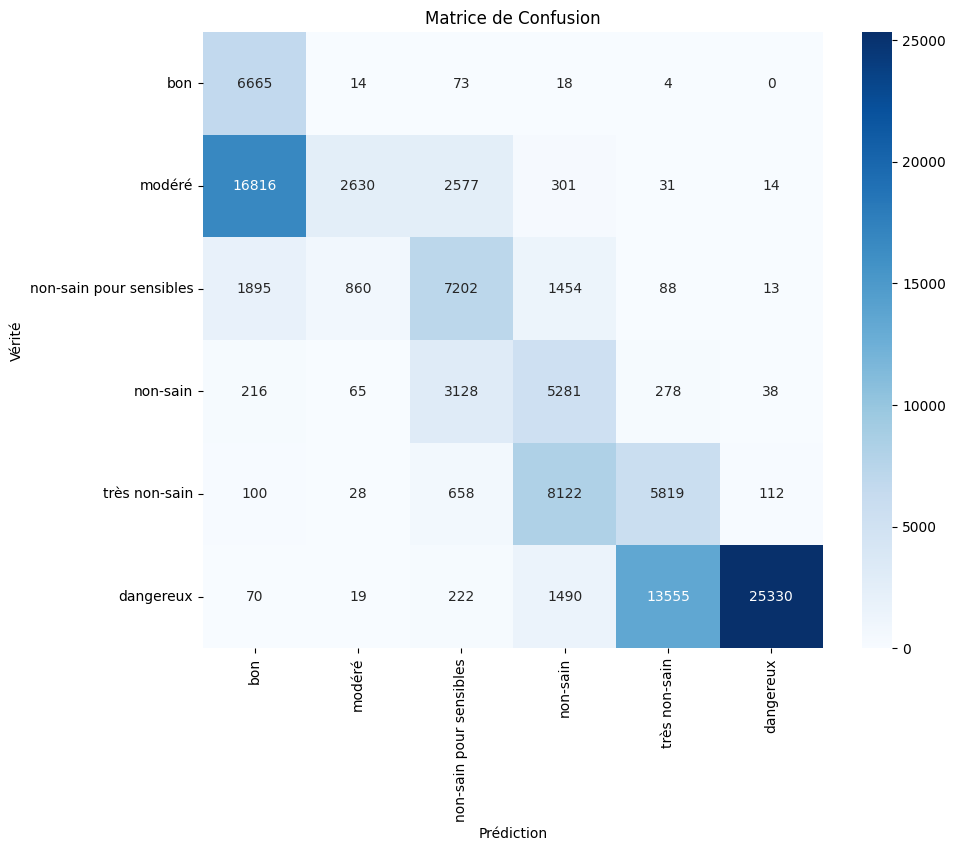

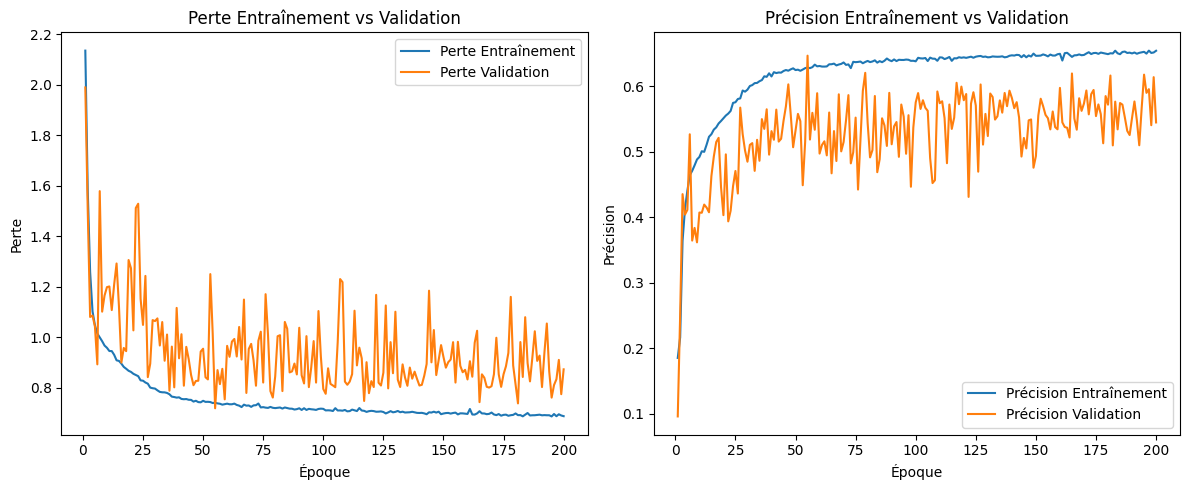

In [ ]:

# -----------------------------
# 19. Visualiser la Matrice de Confusion
# -----------------------------

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Vérité')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.show()

# Obtenir les noms des classes
class_names = desired_order

# Afficher la matrice de confusion
plot_confusion_matrix(cm, class_names)

# -----------------------------
# 20. Visualiser les Courbes d'Apprentissage
# -----------------------------

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Perte Entraînement')
plt.plot(epochs, val_losses, label='Perte Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Perte Entraînement vs Validation')
plt.legend()

# Précision
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Précision Entraînement')
plt.plot(epochs, val_accuracies, label='Précision Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.title('Précision Entraînement vs Validation')
plt.legend()

plt.tight_layout()
plt.show()


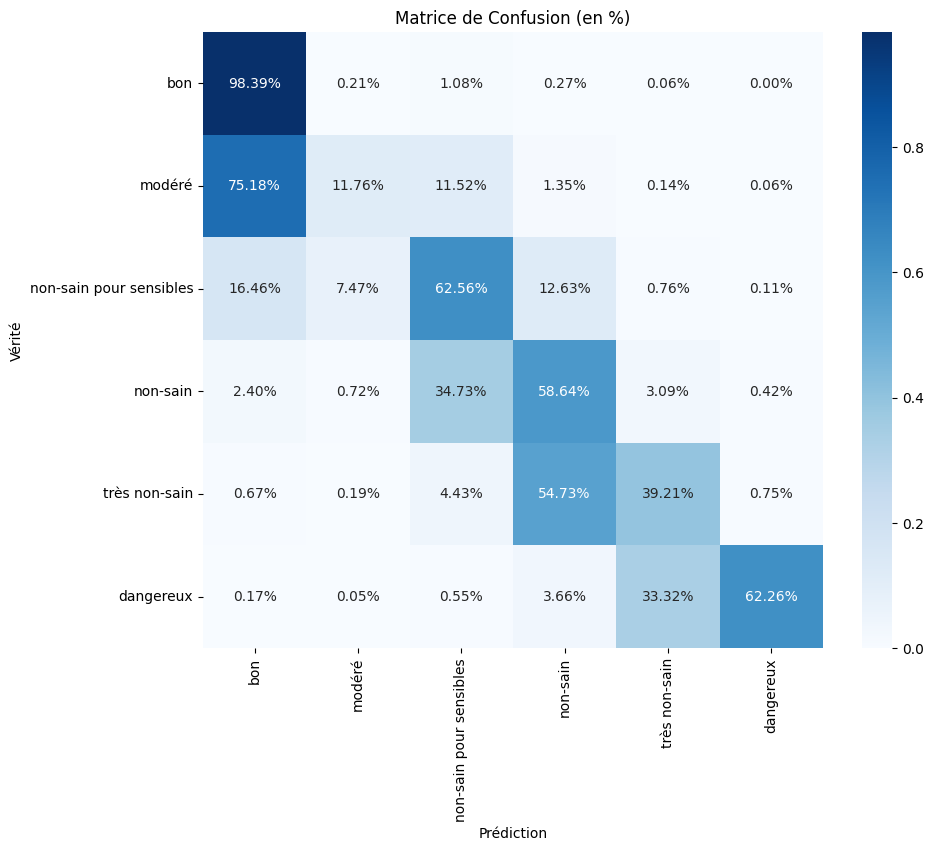

In [ ]:
def plot_confusion_matrix(cm, class_names):
    # Calculer les pourcentages par ligne
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Vérité')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion (en %)')
    plt.show()



# Obtenir les noms des classes
class_names = desired_order

# Afficher la matrice de confusion avec pourcentages
plot_confusion_matrix(cm, class_names)